In [1]:
import sys

import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

import nltk

import re

%matplotlib inline

pd.options.display.max_rows = 15

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("data/train.zip", index_col=['id'])
test = pd.read_csv("data/test.zip", index_col=['id'])
sample_submission = pd.read_csv("data/sample_submission.zip", index_col=['id'])

print(train.shape, test.shape, sample_submission.shape)
sample_submission

(19579, 2) (8392, 1) (8392, 3)


,EAP,HPL,MWS
id,,,
id02310,0.403494,0.287808,0.308698
id24541,0.403494,0.287808,0.308698
id00134,0.403494,0.287808,0.308698
id27757,0.403494,0.287808,0.308698
id04081,0.403494,0.287808,0.308698
id27337,0.403494,0.287808,0.308698
id24265,0.403494,0.287808,0.308698
...,...,...,...
id07156,0.403494,0.287808,0.308698


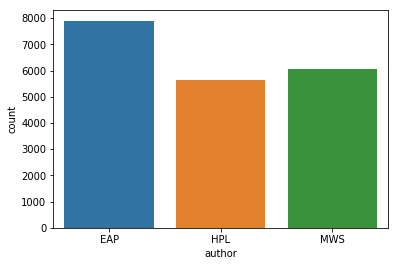

In [3]:
sns.countplot(data=train, x='author');

In [4]:
train_df = train.copy(deep=True)
test_df = test.copy(deep=True)

#### Първо ще пробвам да добавя feature-и за някои препинателни знаци като точки, запетаи, двоеточия и точки и запетаи.

In [5]:
train_df['dots'] =train_df['text'].apply(lambda x: len([c for c in str(x) if c == '.']) )
train_df['commas'] =train_df['text'].apply(lambda x: len([c for c in str(x) if c == ',']) )
train_df['colons'] =train_df['text'].apply(lambda x: len(re.findall("\:", x)) )
train_df['semicolons'] =train_df['text'].apply(lambda x: len(re.findall("\;", x)) )

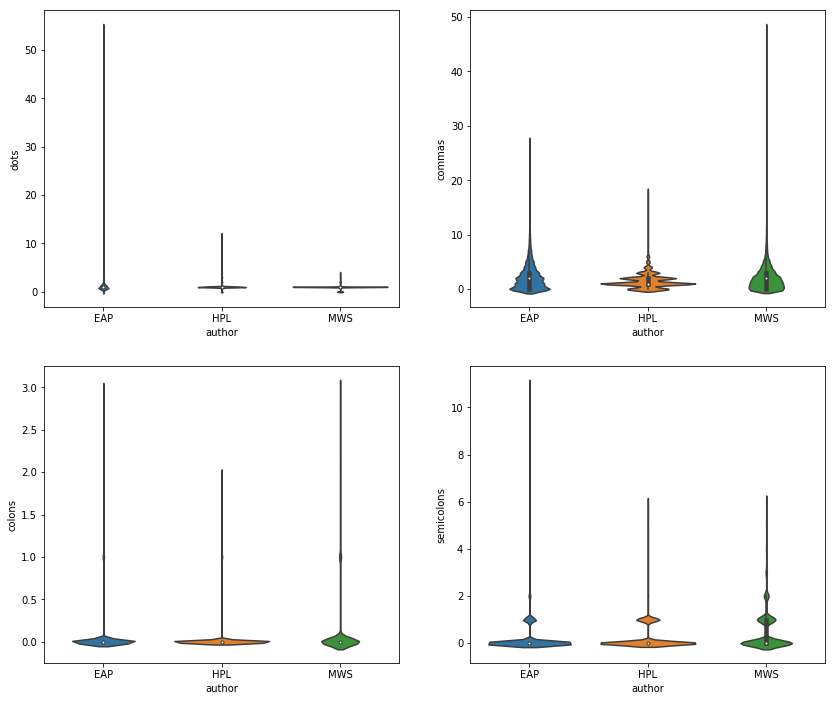

In [6]:
f, axes = plt.subplots(2,2,figsize=(14, 12))
sns.violinplot(x="author", y="dots", data=train_df, ax = axes[0,0])
sns.violinplot(x="author", y="commas", data=train_df, ax = axes[0,1])
sns.violinplot(x="author", y="colons", data=train_df, ax = axes[1,0])
sns.violinplot(x="author", y="semicolons", data=train_df, ax = axes[1,1])

Най-съществени разлики има при точките, запетаите и двоеточията, но оставяме и 4-те feature-а.

Още нещо което ще пробвам е да добавя като feature-и броя на съществителни, глаголи, прилагателни и съюзи. За целта използвам nltk в частност word_tokenize (nltk.download('punkt')) за токенизация на текстовете и pos_tag (nltk.download('averaged_perceptron_tagger')) за определяне на каква част на речта е всяка дума.

Освен това, ще добавя и броя думи, както и броя уникални думи.

In [ ]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

In [7]:
def noun_count(text):
    tokenized_text = nltk.word_tokenize(text)
    tagged_words = nltk.pos_tag(tokenized_text)
    return sum([tag in ('NN','NNP','NNPS','NNS') for word, tag in tagged_words])

def verb_count(text):
    tokenized_text = nltk.word_tokenize(text)
    tagged_words = nltk.pos_tag(tokenized_text)
    return sum([tag in ('VB','VBD','VBG', 'VBN', 'VBP', 'VBZ') for word, tag in tagged_words])

def adjective_count(text):
    tokenized_text = nltk.word_tokenize(text)
    tagged_words = nltk.pos_tag(tokenized_text)
    return sum([tag in ('JJ','JJR','JJS') for word, tag in tagged_words])

def conjunction_count(text):
    tokenized_text = nltk.word_tokenize(text)
    tagged_words = nltk.pos_tag(tokenized_text)
    return sum([tag in ('CC') for word, tag in tagged_words])

def word_count(text):
    return len(text.split())

In [8]:
train_df['nouns'] =train_df['text'].apply(noun_count)
train_df['verbs'] =train_df['text'].apply(verb_count)
train_df['adjectives'] =train_df['text'].apply(adjective_count)
train_df['conjunctions'] =train_df['text'].apply(adjective_count)
train_df['word_count'] =train_df['text'].apply(word_count)
train_df['unique_words'] =train_df['text'].apply(lambda x: len(set(str(x).split())))

Добавям и броя stop words.

In [9]:
stopwords = nltk.corpus.stopwords.words('english')
train_df['stop_words'] =train_df['text'].apply(lambda x: sum(w in stopwords for w in str(x).split()))

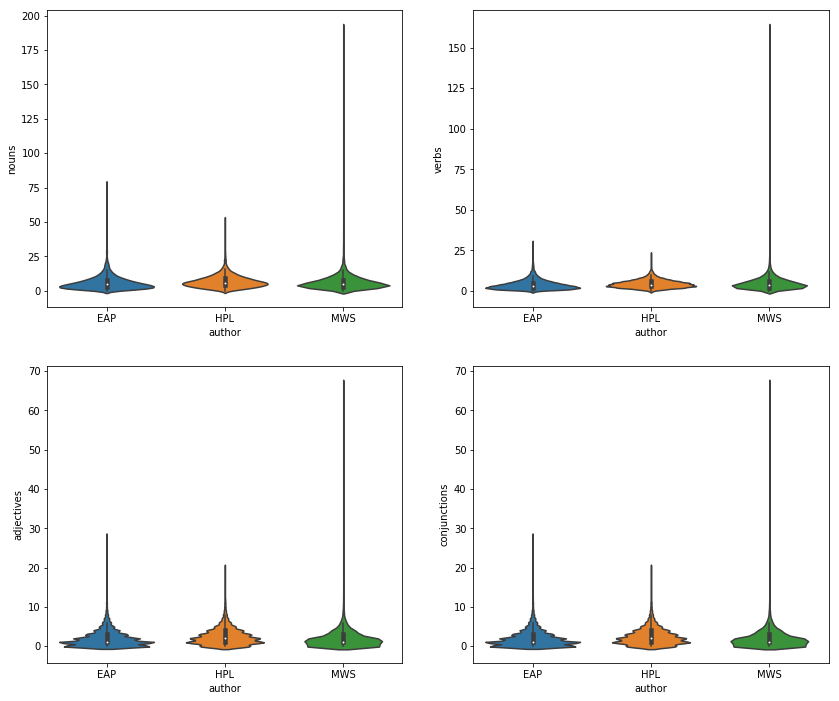

In [10]:
f, axes = plt.subplots(2,2,figsize=(14, 12))
sns.violinplot(x="author", y="nouns", data=train_df, ax = axes[0,0])
sns.violinplot(x="author", y="verbs", data=train_df, ax = axes[0,1])
sns.violinplot(x="author", y="adjectives", data=train_df, ax = axes[1,0])
sns.violinplot(x="author", y="conjunctions", data=train_df, ax = axes[1,1])

Отново забелязваме относителни разлики между използването на съществителни, прилагателни, глаголи и съюзи.

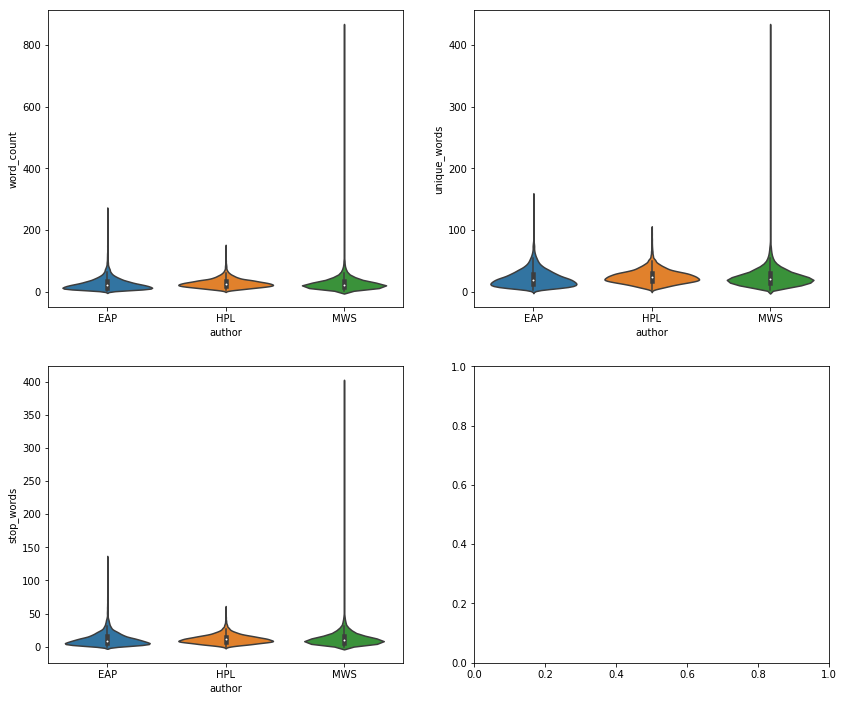

In [11]:
f, axes = plt.subplots(2,2,figsize=(14, 12))
sns.violinplot(x="author", y="word_count", data=train_df, ax = axes[0,0])
sns.violinplot(x="author", y="unique_words", data=train_df, ax = axes[0,1])
sns.violinplot(x="author", y="stop_words", data=train_df, ax = axes[1,0])

Ще използвам tf-idf векторизатор и Multinomial Naive Bayes за модел. Ще прекарам текста през тях и след това ще добавя резултатите като feature-и и ще тренирам различни модели (т. нар. model stacking) - Logistic Regression, RandomForestClassifier.

In [12]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2,
                                 max_df=0.8, lowercase=False)
MNB = MultinomialNB(alpha=0.03)

In [13]:
vectorizer = vectorizer.fit(train_df.text)

In [14]:
transformed_train_text = vectorizer.transform(train_df.text)
transformed_test_text = vectorizer.transform(test_df.text)

Ще използвам StratifiedKFold за крос валидация, защото без него цялата процедура само затвърждаваше вече постигнатите резултати (т.е. ако сме познали сме по-уверени, ако сме сбъркали - бъркаме повече). [Thanks to](https://medium.com/@literallywords/stratified-k-fold-with-keras-e57c487b1416)

In [15]:
splits = 20
cv = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1337)

In [16]:
probabilities = pd.np.zeros([train_df.shape[0], 3])
probabilities_test = 0 

for traincv, testcv in cv.split(transformed_train_text, train_df.author):
    X_train, X_test = transformed_train_text[traincv], transformed_train_text[testcv]
    y_train, y_test = train_df.author[traincv], train_df.author[testcv]
    
    p = MNB.fit(X_train, y_train)
    t_pred = p.predict_proba(transformed_test_text)
    probabilities_test += t_pred
    probabilities[testcv, :] = p.predict_proba(X_test)

probabilities_test /= splits

Добавям получените резултати като нови feature-и в train dataframe-a.

In [17]:
train_df['eap_prediction'] = probabilities[:, 0]
train_df['hpl_prediction'] = probabilities[:, 1]
train_df['mws_prediction'] = probabilities[:, 2]

In [18]:
train_df.columns

Index(['text', 'author', 'dots', 'commas', 'colons', 'semicolons', 'nouns',
       'verbs', 'adjectives', 'conjunctions', 'word_count', 'unique_words',
       'stop_words', 'eap_prediction', 'hpl_prediction', 'mws_prediction'],
      dtype='object')

Да тренираме модели.

In [19]:
def get_x_y(dataframe):
    X = dataframe[dataframe.describe().columns]
    dataframe['author_num'] = dataframe.author.replace(['EAP', 'HPL', 'MWS'], [0, 1, 2])
    y = dataframe['author_num']
    print('X: {}\ny: {}'.format(X.shape, y.shape))
    
    return (X, y)

In [20]:
X, y = get_x_y(train_df)

X: (19579, 14)
y: (19579,)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1337)

In [22]:
model = LogisticRegression()
model.fit(X_train, y_train)

print("Train")
print(cross_val_score(model, X_train, y_train, cv=5, n_jobs=3))
print(cross_val_score(model, X_train, y_train, cv=5, n_jobs=3, 
                      scoring='neg_log_loss'))

Train
[ 0.88053097  0.87265918  0.85427307  0.87091281  0.8722752 ]
[-0.33704023 -0.35302748 -0.38453136 -0.34123757 -0.3437007 ]


In [23]:
print("Test")
print(cross_val_score(model, X_test, y_test, cv=5, n_jobs=3))
print(cross_val_score(model, X_test, y_test, cv=5, n_jobs=3, 
                      scoring='neg_log_loss'))

Test
[ 0.87857143  0.88559755  0.87640449  0.8804903   0.86809816]
[-0.33646913 -0.31102472 -0.3069625  -0.33416341 -0.35642881]


Изглежда впечатляващо добре на test set-a. Нека пробваме и Random Forest.

In [24]:
forest = RandomForestClassifier(random_state=1337)
forest.fit(X_train, y_train)

print("Train")
print(cross_val_score(forest, X_train, y_train, cv=5, n_jobs=3))
print(cross_val_score(forest, X_train, y_train, cv=5, n_jobs=3, 
                      scoring='neg_log_loss'))

Train
[ 0.86827774  0.86108274  0.84576098  0.86546322  0.86818801]
[-1.16632161 -1.14407988 -1.48690358 -1.01896035 -1.18873861]


In [25]:
print("Test")
print(cross_val_score(forest, X_test, y_test, cv=5, n_jobs=3))
print(cross_val_score(forest, X_test, y_test, cv=5, n_jobs=3, 
                      scoring='neg_log_loss'))

Test
[ 0.86632653  0.87129724  0.87334014  0.87436159  0.8599182 ]
[-1.06611274 -0.81471707 -1.05901405 -1.20135704 -1.34692267]


Нещо не е наред. Да пуснем grid search за да намерим подходящи хиперпараметри.

In [26]:
n_estimators=[10, 50, 100, 150, 200, 250]
max_depths=[4, 6, 10, 12, 15]
hyper={'n_estimators':n_estimators,
           'max_depth':max_depths}
gd=GridSearchCV(estimator=RandomForestClassifier(random_state=1337),param_grid=hyper,verbose=True)
gd.fit(X,y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  3.6min finished


0.873486899229
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=1337, verbose=0,
            warm_start=False)


In [27]:
forest = RandomForestClassifier(random_state=1337, n_estimators=150 , max_depth=12)
forest.fit(X_train, y_train)

print("Train")
print(cross_val_score(forest, X_train, y_train, cv=5, n_jobs=3))
print(cross_val_score(forest, X_train, y_train, cv=5, n_jobs=3, 
                      scoring='neg_log_loss'))

Train
[ 0.88053097  0.87299966  0.855635    0.8746594   0.8743188 ]
[-0.33331302 -0.34038922 -0.36700105 -0.32625686 -0.32934034]


In [28]:
print("Test")
print(cross_val_score(forest, X_test, y_test, cv=5, n_jobs=3))
print(cross_val_score(forest, X_test, y_test, cv=5, n_jobs=3, 
                      scoring='neg_log_loss'))

Test
[ 0.88163265  0.88151175  0.8845761   0.88151175  0.86707566]
[-0.33033786 -0.30423387 -0.31202397 -0.33729089 -0.349735  ]


### Време за submit в kaggle. Първо трябва да преобразим и test_df.

In [29]:
test_df['dots'] =test_df['text'].apply(lambda x: len([c for c in str(x) if c == '.']) )
test_df['commas'] =test_df['text'].apply(lambda x: len([c for c in str(x) if c == ',']) )
test_df['colons'] =test_df['text'].apply(lambda x: len(re.findall("\:", x)) )
test_df['semicolons'] =test_df['text'].apply(lambda x: len(re.findall("\;", x)) )

test_df['nouns'] =test_df['text'].apply(noun_count)
test_df['verbs'] =test_df['text'].apply(verb_count)
test_df['adjectives'] =test_df['text'].apply(adjective_count)
test_df['conjunctions'] =test_df['text'].apply(adjective_count)
test_df['word_count'] =test_df['text'].apply(word_count)
test_df['unique_words'] =test_df['text'].apply(lambda x: len(set(str(x).split())))

test_df['stop_words'] =test_df['text'].apply(lambda x: sum(w in stopwords for w in str(x).split()))

test_df['eap_prediction'] = probabilities_test[:, 0]
test_df['hpl_prediction'] = probabilities_test[:, 1]
test_df['mws_prediction'] = probabilities_test[:, 2]

In [30]:
train_df.columns

Index(['text', 'author', 'dots', 'commas', 'colons', 'semicolons', 'nouns',
       'verbs', 'adjectives', 'conjunctions', 'word_count', 'unique_words',
       'stop_words', 'eap_prediction', 'hpl_prediction', 'mws_prediction',
       'author_num'],
      dtype='object')

In [31]:
test_df.columns

Index(['text', 'dots', 'commas', 'colons', 'semicolons', 'nouns', 'verbs',
       'adjectives', 'conjunctions', 'word_count', 'unique_words',
       'stop_words', 'eap_prediction', 'hpl_prediction', 'mws_prediction'],
      dtype='object')

In [32]:
prediction_test = forest.predict_proba(test_df[test_df.describe().columns])

In [33]:
forest.classes_

array([0, 1, 2], dtype=int64)

In [34]:
submit_file_test = pd.DataFrame(prediction_test, columns=['EAP', 'HPL', 'MWS'], index=test_df.index)
submit_file_test.head(10)

,EAP,HPL,MWS
id,,,
id02310,0.029587,0.013839,0.956573
id24541,0.999049,0.000303,0.000647
id00134,0.000463,0.884576,0.114961
id27757,0.801902,0.165542,0.032556
id04081,0.671786,0.198480,0.129735
id27337,0.984770,0.010344,0.004885
id24265,0.950050,0.032996,0.016953
id25917,0.016736,0.008260,0.975004
id04951,0.996239,0.001793,0.001968


In [35]:
submit_file_test.to_csv("data/forest.csv")

## Резултати:
- RandomForestClassifier = 0.35916
- Logistic Regression = 0.37541